# Testing evaluation Video Making

Generating an overlay frame for visual inspection

In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import torch
import torch.nn.functional as F

import os

In [3]:
path_to_data = "/share/data_ultraschall/compressions"

In [4]:
# load the quality overview
quality = pd.read_csv("~/quality.csv")

# More info about the sequences
sequences = pd.read_csv("~/sequences.csv")

In [5]:
quality

,ID,Vessel in Frame,LM configuration,Vein contrast/cropping error,Artery contrast,Vein boundary,Artery boundary,Gain,Depth,Artefacts,Movement,Total
0,113.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,17
1,116.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,11
2,119.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,12
3,120.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,16
4,121.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...
4762,11276.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,1.0,17
4763,11277.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,14
4764,11278.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,16
4765,11280.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,12


In [6]:
sequences

,Id,Patient,Device,Leg,Anatomy,Landmark,Datatype
0,1,1,guys,RT,SFV1,LM5,healthy
1,2,1,guys,RT,SFV2,LM6,healthy
2,3,1,guys,LT,CFV / GSV + SFA / PFA,LM3,healthy
3,4,1,guys,LT,SFV1,LM5,healthy
4,5,1,guys,LT,SFV2,LM6,healthy
...,...,...,...,...,...,...,...
3862,5396,228,philips,LT,GSV / CFV + SFA / PFA,"LM1,LM3",healthy
3863,5397,224,philips,RT,POPV,LM8,healthy
3864,5682,280,philips,RT,SFV + SFA,LM6,healthy
3865,5687,282,philips,RT,SFV + SFA,LM6,healthy


In [10]:
# filter based on the table above
useable = quality[
    (quality["Vessel in Frame"] <3) &
    (quality['LM configuration'] < 4) &
    (quality['Vein contrast/cropping error'] < 3) &
    (quality['Artery contrast'] < 3) &
    (quality['Vein boundary'] < 3) &
    (quality['Artery boundary'] < 3) &
    (quality['Gain'] == 1) &
    (quality['Artefacts'] < 3) &
    (quality['Movement'] < 3) &
    (quality['Total'] < 21)
]
useable

# filter based on useable
overview = sequences[sequences.Id.isin(useable.index.tolist())]
overview

,Id,Patient,Device,Leg,Anatomy,Landmark,Datatype
0,1,1,guys,RT,SFV1,LM5,healthy
1,2,1,guys,RT,SFV2,LM6,healthy
2,3,1,guys,LT,CFV / GSV + SFA / PFA,LM3,healthy
4,5,1,guys,LT,SFV2,LM6,healthy
5,6,1,guys,RT,POP-TRUNK,LM9,healthy
...,...,...,...,...,...,...,...
3265,4754,343,philips,RT,SFV + SFA,LM7,healthy
3266,4755,343,philips,RT,SFV + SFA,LM7,healthy
3272,4761,343,philips,RT,POPV,LM8,not closing
3274,4763,343,philips,RT,POPV,LM8,invalid compression


In [14]:
overview_clean = overview[overview['Id'].astype(str).isin(os.listdir(path_to_data))]
overview_clean

,Id,Patient,Device,Leg,Anatomy,Landmark,Datatype
2,3,1,guys,LT,CFV / GSV + SFA / PFA,LM3,healthy
8,9,2,guys,RT,SFV1,LM5,healthy
9,10,2,guys,RT,SFV2,LM6,healthy
18,19,3,guys,LT,CFV,LM3,healthy
19,20,3,guys,LT,SFV1,LM5,healthy
...,...,...,...,...,...,...,...
3259,4748,343,philips,RT,SFV + SFA,LM6,healthy
3260,4749,343,philips,RT,POPV,LM8,healthy
3263,4752,343,philips,RT,POPV,LM8,healthy
3265,4754,343,philips,RT,SFV + SFA,LM7,healthy


In [18]:
available_seg = []
for proband in os.listdir(path_to_data):
    proband_path = os.path.join(path_to_data,str(proband))
    if "segmentations" in os.listdir(proband_path):
        available_seg.append(proband)
len(available_seg)

1330

In [26]:
for proband in available_seg:
    available_frames = len(os.listdir(os.path.join(path_to_data,proband,'frames')))
    if available_frames > 200:
        print(f"There are {available_frames} frames available for id {proband}")

There are 281 frames available for id 316
There are 208 frames available for id 2724
There are 223 frames available for id 1164
There are 261 frames available for id 307
There are 481 frames available for id 822
There are 205 frames available for id 2041
There are 203 frames available for id 717
There are 208 frames available for id 195
There are 481 frames available for id 827
There are 236 frames available for id 157
There are 273 frames available for id 821
There are 230 frames available for id 379
There are 239 frames available for id 327
There are 227 frames available for id 1395
There are 255 frames available for id 2033
There are 202 frames available for id 797
There are 446 frames available for id 1562
There are 231 frames available for id 161
There are 201 frames available for id 658
There are 222 frames available for id 1406
There are 221 frames available for id 1274
There are 227 frames available for id 1396
There are 238 frames available for id 1393
There are 227 frames ava

In [85]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

import torch
import torch.nn
import torch.nn.functional as F

from PIL import Image

In [119]:
prob_id='1164'
frame_path = os.path.join(path_to_data,prob_id,'frames')
seg_path = os.path.join(path_to_data,prob_id,'segmentations','1')

In [120]:
frame_list = []
for frame in os.listdir(frame_path):
    frame_list.append(os.path.join(frame_path,frame))
frame_list.sort()

In [121]:
seg_list = []
for seg in os.listdir(seg_path):
    seg_list.append(os.path.join(seg_path,seg))
seg_list.sort()

In [122]:
print(f"{len(seg_list)} Segmentations and {len(frame_list)} Frames")

223 Segmentations and 223 Frames


In [123]:
# check if the overlay works
def overlaySegment(gray1,seg1,flag=False):
    H, W = seg1.squeeze().size()
    colors=torch.FloatTensor([0,0,0,199,67,66,225,140,154,78,129,170,45,170,170,240,110,38,111,163,91,235,175,86,202,255,52,162,0,183]).view(-1,3)/255.0
    segs1 = labelMatrixOneHot(seg1.unsqueeze(0),8)

    seg_color = torch.mm(segs1.view(8,-1).t(),colors[:8,:]).view(H,W,3)
    alpha = torch.clamp(1.0 - 0.5*(seg1>0).float(),0,1.0)

    overlay = (gray1*alpha).unsqueeze(2) + seg_color*(1.0-alpha).unsqueeze(2)
    if(flag):
        plt.imshow((overlay).numpy())
        plt.show()
    return overlay
def labelMatrixOneHot(segmentation, label_num):
    B, H, W = segmentation.size()
    values = segmentation.view(B,1,H,W).expand(B,label_num,H,W).to(segmentation.device)
    linspace = torch.linspace(0, label_num-1, label_num).long().view(1,label_num,1,1).expand(B,label_num,H,W).to(segmentation.device)
    matrix = (values.float()==linspace.float()).float().to(segmentation.device)
    for j in range(2,matrix.shape[1]):
        matrix[0,j,:,:] = matrix[0,j,:,:]
    return matrix

<IPython.core.display.Javascript object>


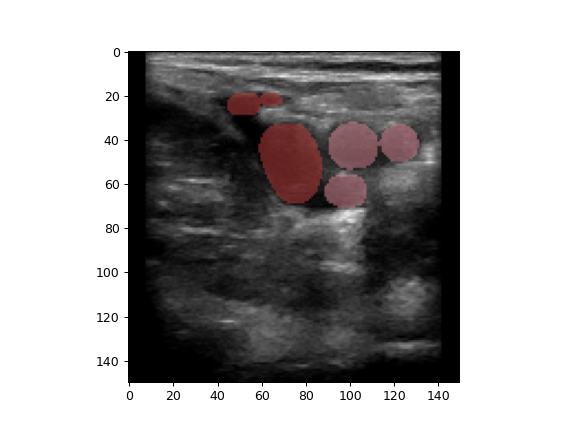

In [124]:
%matplotlib notebook
assert len(frame_list) == len(seg_list)

frs = []
fig = plt.figure()
for i in range(len(frame_list)):
    loaded_frame = torch.from_numpy(np.array(Image.open(frame_list[i]))) / 255
    loaded_seg = torch.from_numpy(np.array(Image.open(seg_list[i]))) / 100

    overlay = overlaySegment(loaded_frame, loaded_seg, False)
    frs.append([plt.imshow(overlay, animated=True)])

ani = animation.ArtistAnimation(fig, frs, interval=50, blit=True, repeat_delay=1000)
plt.show()